# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '02'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedice"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 265513)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 16:33:46 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedice.values
    n_s  = xr.open_dataset(fname).n_rimedice.values
    r_s  = xr.open_dataset(fname).rime_rimedice.values
    v_s  = xr.open_dataset(fname).rvol_rimedice.values
    a_s  = xr.open_dataset(fname).rimedice_area.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-20
    # ice density
    rhoi = 916.7
    # reff following Fu (1996) and Foot (1988), here Eq. (3.11) of Fu (1996)
    reff = np.where(n_s>q_min,3./4.*q_s/(a_s*n_s*rhoi),np.nan)   
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    reff = np.log(reff, where=reff>p_min, out=np.nan*reff)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, r_s, v_s, reff ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'n_s', 'r_s', 'v_s', 'reff' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

In [8]:
df.describe()

q_s            n_s            r_s            v_s  \
count  262632.000000  262632.000000  262632.000000  262632.000000   
mean      -12.166051       7.182906     -13.320219     -18.655182   
std         2.555933       2.717398       2.767870       2.823814   
min       -22.398951     -14.498609     -22.608919     -27.630821   
25%       -13.693205       5.711685     -15.017660     -20.385937   
50%       -12.094987       7.334786     -13.267910     -18.603462   
75%       -10.338549       8.977478     -11.424548     -16.747011   
max        -4.456319      16.136034      -4.653678     -11.166290   

                reff  
count  262632.000000  
mean      -10.238617  
std         0.540928  
min       -11.586338  
25%       -10.579351  
50%       -10.369553  
75%       -10.045981  
max        -2.692828

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       n_s        r_s        v_s       reff
1 -11.692698  7.744050 -15.343876 -20.366152 -10.584973
2 -11.652073  7.759742 -14.838218 -19.867702 -10.571924
3 -11.620110  7.761234 -14.531169 -19.568178 -10.559849
4 -11.591861  7.757564 -14.299613 -19.343794 -10.547618
5 -11.564956  7.753838 -14.119457 -19.170822 -10.536296

In [11]:
dataset_train.describe()

q_s            n_s            r_s            v_s  \
count  183964.000000  183964.000000  183964.000000  183964.000000   
mean      -12.160447       7.189328     -13.313702     -18.648819   
std         2.554455       2.716783       2.765299       2.821156   
min       -22.398951     -14.498609     -22.608919     -27.630821   
25%       -13.687755       5.723062     -15.008156     -20.376437   
50%       -12.087028       7.336937     -13.259989     -18.595183   
75%       -10.335279       8.979165     -11.419071     -16.742371   
max        -4.456319      16.097975      -4.655664     -11.166290   

                reff  
count  183964.000000  
mean      -10.238717  
std         0.541743  
min       -11.497607  
25%       -10.580454  
50%       -10.369646  
75%       -10.046233  
max        -2.692828

In [12]:
dataset_test.describe()

q_s           n_s           r_s           v_s          reff
count  39669.000000  39669.000000  39669.000000  39669.000000  39669.000000
mean     -12.170331      7.180086    -13.327258    -18.662148    -10.242234
std        2.553257      2.718537      2.764554      2.820092      0.539132
min      -21.860920    -14.498609    -22.510994    -27.625536    -11.586338
25%      -13.690376      5.701146    -15.031151    -20.397781    -10.577035
50%      -12.112000      7.332042    -13.279251    -18.619314    -10.371325
75%      -10.357554      8.986509    -11.440232    -16.766670    -10.050208
max       -4.581258     16.136034     -4.804121    -11.389381     -2.886015

In [13]:
dataset_val.describe()

q_s           n_s           r_s           v_s          reff
count  38999.000000  38999.000000  38999.000000  38999.000000  38999.000000
mean     -12.188141      7.155482    -13.343812    -18.678083    -10.234468
std        2.565547      2.719036      2.783246      2.840020      0.538886
min      -22.214920    -14.498609    -22.460083    -27.621763    -11.460229
25%      -13.720519      5.667585    -15.048569    -20.419538    -10.575963
50%      -12.115647      7.315884    -13.294338    -18.628086    -10.366554
75%      -10.340489      8.962257    -11.429596    -16.752889    -10.041166
max       -4.461589     15.942718     -4.653678    -11.350211     -2.699370

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['n_s'] < -10 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s            n_s            r_s            v_s  \
count  182967.000000  182967.000000  182967.000000  182967.000000   
mean      -12.121933       7.243060     -13.279065     -18.612600   
std         2.486758       2.605822       2.712470       2.769302   
min       -19.999880      -3.465736     -22.608919     -27.626930   
25%       -13.666616       5.756960     -14.981385     -20.350910   
50%       -12.073677       7.354874     -13.246906     -18.580614   
75%       -10.328594       8.989656     -11.411904     -16.735228   
max        -5.269536      16.097975      -5.991785     -11.166290   

                reff  
count  182967.000000  
mean      -10.243308  
std         0.516454  
min       -11.497607  
25%       -10.580586  
50%       -10.370745  
75%       -10.048578  
max        -7.737141

In [17]:
dataset_test.describe()

q_s           n_s           r_s           v_s          reff
count  39466.000000  39466.000000  39466.000000  39466.000000  39466.000000
mean     -12.135332      7.231585    -13.295968    -18.629213    -10.247128
std        2.491494      2.609451      2.716357      2.772824      0.511647
min      -19.983999     -3.086204    -22.510994    -27.624344    -11.586338
25%      -13.669421      5.731236    -15.006855    -20.371799    -10.577179
50%      -12.099229      7.348330    -13.268430    -18.603715    -10.372345
75%      -10.350502      8.995946    -11.436381    -16.760892    -10.052732
max       -5.333592     16.136034     -6.256629    -11.389381     -7.856954

### Pairplot

In [18]:
sns.pairplot(dataset_train[["reff","q_s","n_s","r_s","v_s"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
#train_dataset1 = train_dataset1.drop(['temp','rho'], axis=1)
#train_dataset2 = train_dataset2.drop(['temp'], axis=1)
#train_dataset3 = train_dataset3.drop(['temp','rho'], axis=1)

In [23]:
#test_dataset1 = test_dataset1.drop(['temp','rho'], axis=1)
#test_dataset2 = test_dataset2.drop(['temp'], axis=1)
#test_dataset3 = test_dataset3.drop(['temp','rho'], axis=1)

In [24]:
#val_dataset1 = val_dataset1.drop(['temp','rho'], axis=1)
#val_dataset2 = val_dataset2.drop(['temp'], axis=1)
#val_dataset3 = val_dataset3.drop(['temp','rho'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("reff")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s  182967.0 -12.121933  2.486758 -19.999880 -13.666616 -12.073677   
n_s  182967.0   7.243060  2.605822  -3.465736   5.756960   7.354874   
r_s  182967.0 -13.279065  2.712470 -22.608919 -14.981385 -13.246906   
v_s  182967.0 -18.612600  2.769302 -27.626930 -20.350910 -18.580614   

           75%        max  
q_s -10.328594  -5.269536  
n_s   8.989656  16.097975  
r_s -11.411904  -5.991785  
v_s -16.735228 -11.166290

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [26]:
# pop does not work for multiple columns, use copy instead

labels = ['reff']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [27]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [28]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [29]:
train_labels.describe()

reff
count  182967.000000
mean      -10.243308
std         0.516454
min       -11.497607
25%       -10.580586
50%       -10.370745
75%       -10.048578
max        -7.737141

In [30]:
train_dataset1.describe()

q_s            n_s            r_s            v_s
count  182967.000000  182967.000000  182967.000000  182967.000000
mean      -12.121933       7.243060     -13.279065     -18.612600
std         2.486758       2.605822       2.712470       2.769302
min       -19.999880      -3.465736     -22.608919     -27.626930
25%       -13.666616       5.756960     -14.981385     -20.350910
50%       -12.073677       7.354874     -13.246906     -18.580614
75%       -10.328594       8.989656     -11.411904     -16.735228
max        -5.269536      16.097975      -5.991785     -11.166290

### Normalize the features

In [31]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)

normed_test_data1 = norm(test_dataset1,train_stats1)

normed_val_data1 = norm(val_dataset1,train_stats1)

In [32]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s  182967.0  6.326112e-07  1.0 -3.167959 -0.621164  0.019405  0.721155   
n_s  182967.0 -2.470229e-07  1.0 -4.109565 -0.570300  0.042909  0.670267   
r_s  182967.0 -4.652543e-07  1.0 -3.439616 -0.627590  0.011856  0.688362   
v_s  182967.0  1.487661e-07  1.0 -3.255091 -0.627707  0.011550  0.677923   

          max  
q_s  2.755555  
n_s  3.398127  
r_s  2.686585  
v_s  2.688876

### Normalize the labels

In [33]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
reff  182967.0 -10.243308  0.516454 -11.497607 -10.580586 -10.370745   

            75%       max  
reff -10.048578 -7.737141

In [34]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [35]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H2(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H1(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H1":
        model = build_model_relu_Adam_H1(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H2":
        model = build_model_relu_Adam_H2(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [36]:

activ = "ReLU_Adam_H1"

model = build_model(4,8,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [38]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.04864802],
       [-0.02229948],
       [-0.01157783],
       [-0.00512716],
       [-0.00190714],
       [-0.00346297],
       [-0.00511222],
       [-0.0073377 ],
       [-0.02594941],
       [-0.03749555]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [39]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [40]:
nsize = 8
activ = "ReLU_Adam_H1"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1741,  mae:0.2459,  mse:0.1741,  val_loss:0.1296,  val_mae:0.1828,  val_mse:0.1296,  
...............................................................

In [41]:
histories['ReLU_H1_n8'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0,0.20])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

In [42]:
nsize = 16
model2 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1666,  mae:0.2362,  mse:0.1666,  val_loss:0.1312,  val_mae:0.1838,  val_mse:0.1312,  
.............................................................................................

Text(0, 0.5, 'MAE')

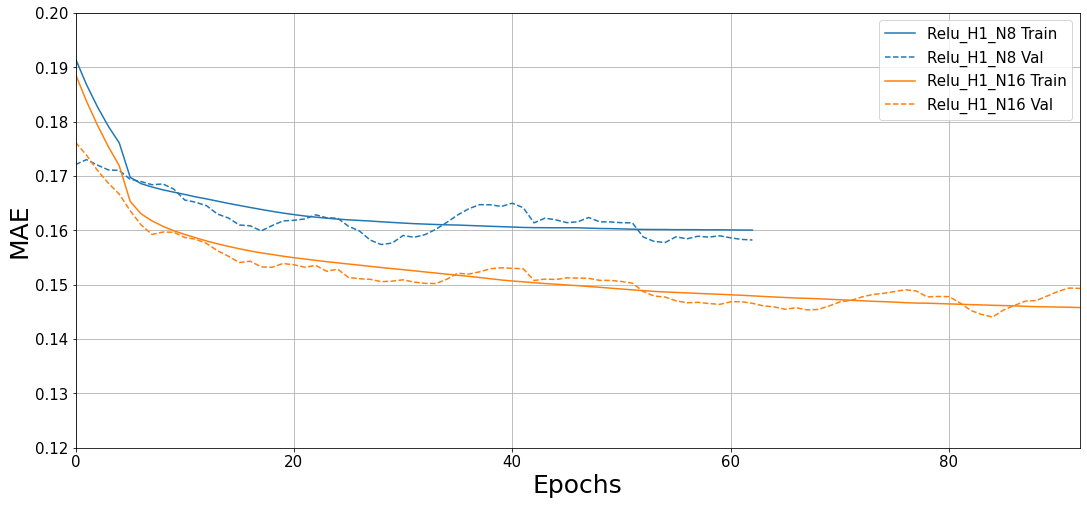

In [44]:
histories['ReLU_H1_n16'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.12, 0.2])
plt.ylabel('MAE')

In [45]:
nsize = 32
model3 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1603,  mae:0.2189,  mse:0.1603,  val_loss:0.1282,  val_mae:0.1869,  val_mse:0.1282,  
...................................................................

In [46]:
histories['ReLU_H1_n32'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.12, 0.2])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

In [47]:
nsize = 8
activ = "ReLU_Adam_H2"
model4 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1994,  mae:0.2642,  mse:0.1994,  val_loss:0.1516,  val_mae:0.2255,  val_mse:0.1516,  
..................................................................................

In [48]:
histories['ReLU_H2_n6'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.12, 0.2])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

In [49]:
nsize = 16
model5 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1700,  mae:0.2245,  mse:0.1700,  val_loss:0.1284,  val_mae:0.1928,  val_mse:0.1284,  
....................................................................................

Text(0, 0.5, 'MAE')

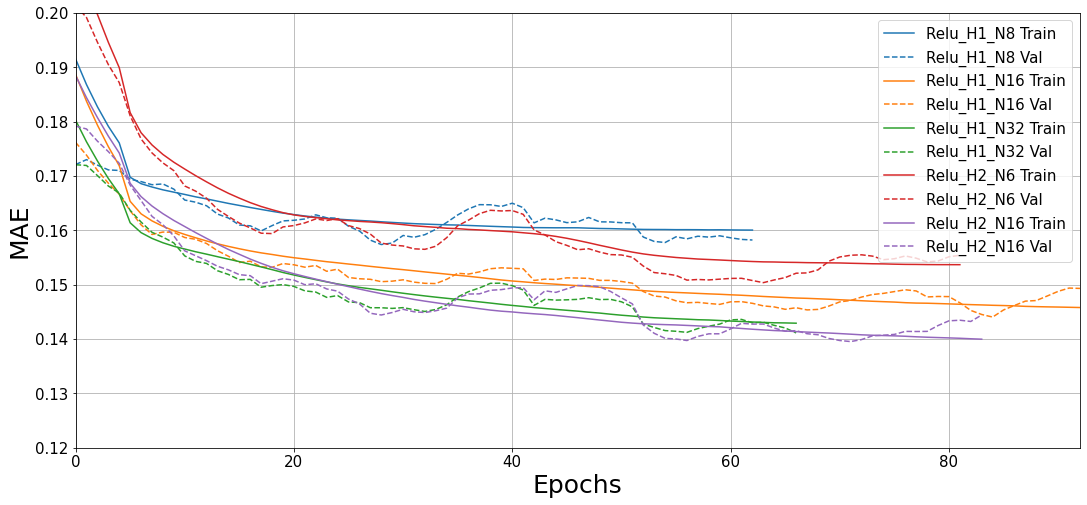

In [50]:
histories['ReLU_H2_n16'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.12, 0.2])
plt.ylabel('MAE')

In [51]:
nsize = 32
model6 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history6 = model6.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1482,  mae:0.2114,  mse:0.1482,  val_loss:0.1237,  val_mae:0.1942,  val_mse:0.1237,  
.............................................................................................

In [52]:
histories['ReLU_H2_n32'] = early_history6

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.12, 0.2])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

Text(0, 0.5, 'MSE')

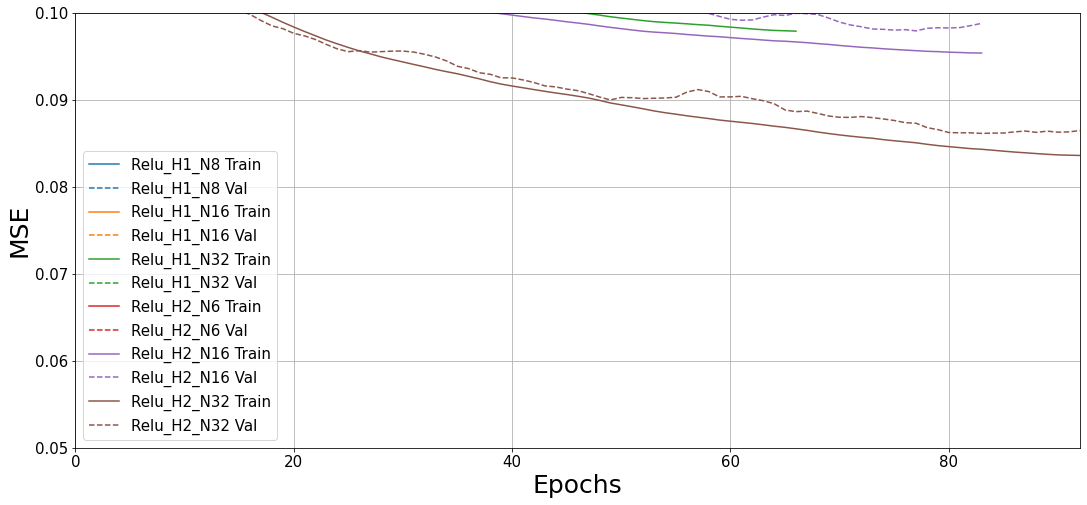

In [53]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.05, 0.1])
plt.ylabel('MSE')

In [54]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

39466/39466 - 1s - loss: 0.1130 - mae: 0.1498 - mse: 0.1130
Testing set for model 1, Mean Abs Error:    0.14981


In [55]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

39466/39466 - 1s - loss: 0.1019 - mae: 0.1414 - mse: 0.1019
Testing set for model 2, Mean Abs Error:              0.14141


In [56]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

39466/39466 - 1s - loss: 0.0975 - mae: 0.1384 - mse: 0.0975
Testing set for model 3, Mean Abs Error:              0.13837


In [57]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

39466/39466 - 1s - loss: 0.1057 - mae: 0.1460 - mse: 0.1057
Testing set for model 4, Mean Abs Error:              0.14604


In [58]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

39466/39466 - 1s - loss: 0.0950 - mae: 0.1409 - mse: 0.0950
Testing set for model 5, Mean Abs Error:              0.14086


In [59]:
loss6, mae6, mse6 = model6.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 6, Mean Abs Error: {:20.5f}".format(mae6))

39466/39466 - 1s - loss: 0.0835 - mae: 0.1227 - mse: 0.0835
Testing set for model 6, Mean Abs Error:              0.12269


In [60]:
mae = [ mae1, mae2, mae3, mae4, mae5, mae6 ]
mae

[0.14980705, 0.14140746, 0.13836719, 0.14604169, 0.1408632, 0.12268852]

In [61]:
mse = [ mse1, mse2, mse3, mse4, mse5, mse6 ]
mse

[0.11299508, 0.10188969, 0.09747737, 0.10570861, 0.09495055, 0.08351287]

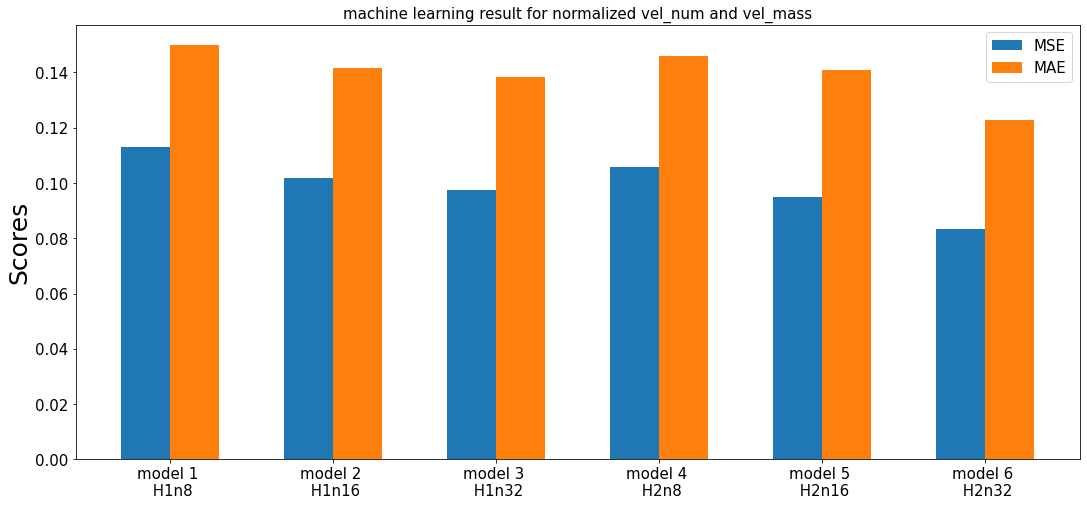

In [62]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1 \n H1n8',
 'model 2 \n H1n16',
 'model 3 \n H1n32',
 'model 4 \n H2n8',
 'model 5 \n H2n16',
 'model 6 \n H2n32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized vel_num and vel_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [63]:
test_true_num  = np.exp(test_labels.pop('reff'))

In [64]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [65]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["reff"])

In [66]:
p1.describe()

reff
count  39466.000000
mean      -0.018793
std        0.929288
min       -2.329282
25%       -0.622823
50%       -0.199823
75%        0.368446
max        4.269546

In [67]:
train_labels_stats

count       mean       std        min        25%        50%  \
reff  182967.0 -10.243308  0.516454 -11.497607 -10.580586 -10.370745   

            75%       max  
reff -10.048578 -7.737141

In [68]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [69]:
test_predict1.describe()

reff
count  39466.000000
mean       0.000041
std        0.000031
min        0.000011
25%        0.000026
50%        0.000032
75%        0.000043
max        0.000323

In [70]:
test_predict1_num  = test_predict1['reff']

In [71]:

p2 = pd.DataFrame(data=model2.predict(normed_test_data1), columns=["reff"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_num  = test_predict2['reff']

In [72]:

p3 = pd.DataFrame(data=model3.predict(normed_test_data1), columns=["reff"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_num  = test_predict3['reff']

### Maybe the ordering of the arrays is different? 

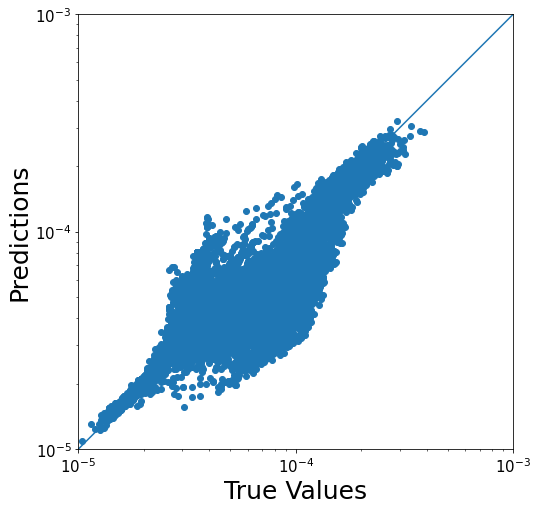

In [73]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-5, 1e-3

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict1_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

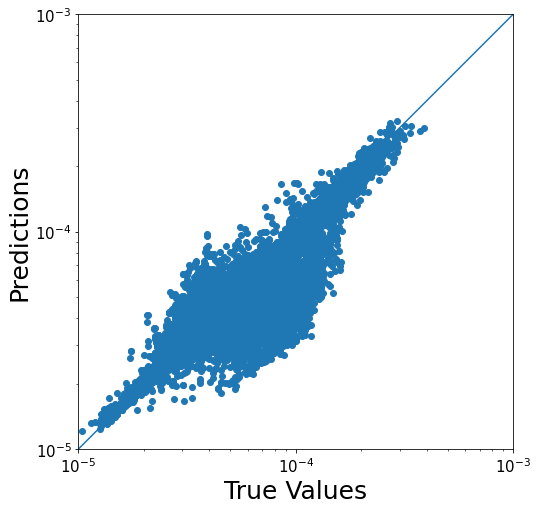

In [74]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict2_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

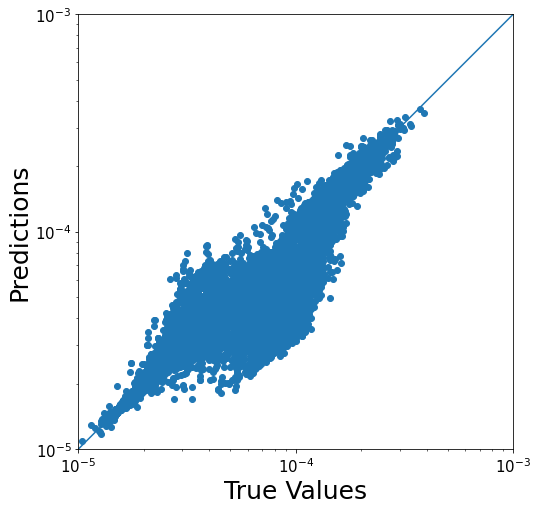

In [75]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict3_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [76]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [77]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [78]:
features = 'q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice'
labels   = 'reff_rimedice'
logtransform = np.array([True, True, True, True], dtype=bool)

filename = 'saved_model_v2/reff_rimedice_model1_'+version+'.nc'
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,filename)
save2netcdf(model2,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_rimedice_model2_'+version+'.nc')
save2netcdf(model3,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_rimedice_model3_'+version+'.nc')
save2netcdf(model4,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_rimedice_model4_'+version+'.nc')
save2netcdf(model5,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_rimedice_model5_'+version+'.nc')
save2netcdf(model6,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_rimedice_model6_'+version+'.nc')


Saving model to saved_model_v2/reff_rimedice_model1_02.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice
  Labels:     reff_rimedice
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 8), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 8), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 1), Activation: linear
Saving model to saved_model_v2/reff_rimedice_model2_02.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice
  Labels:     reff_rimedice
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/reff_rimedice_model3_02.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice
  Labels:     reff_rimed